In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.optimize import minimize
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from pathlib import Path

In [2]:
# Images directory

figsdir = Path.cwd() / 'ex5figs'
figsdir.mkdir(parents=True, exist_ok=True);

In [3]:
# Data directory

datadir = Path.cwd() / 'data/ex5'

# Regularized linear regression

In [4]:
data = loadmat(datadir / 'ex5data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])

In [5]:
x = data['X']
y = data['y']

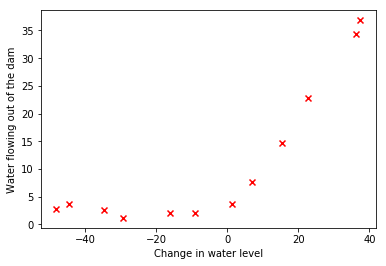

In [6]:
# Plot the data

plt.scatter(x, y, marker='x', c='r')
plt.xlabel('Change in water level')
plt.ylabel('Water flowing out of the dam')

plt.savefig(figsdir / 'data.png', bbox_inches='tight')

In [7]:
def cost_function(theta, x, y, reg=0):
    m = len(x)
    h = x.dot(theta).reshape(-1, 1)
    
    J = (np.sum(np.square(h - y)) + reg * np.sum(np.square(theta[1:]))) / (2 * m)
    
    grad = np.zeros(theta.shape)
    grad[0] = np.sum(h - y) / m
    grad[1:] = ((h - y).T.dot(x[:, 1:]) + reg * theta[1:]) / m
    
    return J, grad

In [8]:
x = np.c_[np.ones(x.shape[0]), x]
theta = np.array([1, 1])

J, grad = cost_function(theta, x, y, reg=1)

print('Cost at theta = [1, 1] (w/ lambda = 1): {}\n(this value should be about 303.993)'.format(J))
print('Cost at theta = [1, 1] (w/ lambda = 1): {}\n(this value should be about [-15.303016; 598.250744])'.format(grad))

Cost at theta = [1, 1] (w/ lambda = 1): 303.9931922202643
(this value should be about 303.993)
Cost at theta = [1, 1] (w/ lambda = 1): [-15.30301567 598.25074417]
(this value should be about [-15.303016; 598.250744])


In [9]:
def train_regression(x, y, reg, iterations):
    initial_theta = np.zeros(x.shape[1])
    res = minimize(cost_function, initial_theta, args=(x, y, reg), method='CG', jac=True, options={'maxiter': iterations})
    
    return res.x

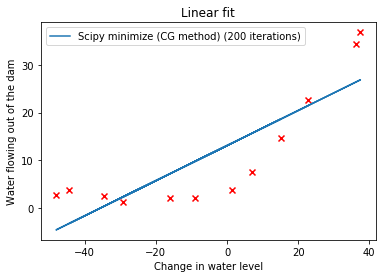

In [10]:
iterations = 200
theta = train_regression(x, y, reg=0, iterations=iterations)

# Display the linear fit

plt.scatter(x[:, 1], y, marker='x', c='r')
plt.plot(x[:, 1], x.dot(theta), label='Scipy minimize (CG method) ({} iterations)'.format(iterations));

plt.title('Linear fit')
plt.xlabel('Change in water level')
plt.ylabel('Water flowing out of the dam')
plt.legend(loc='best')

plt.savefig(figsdir / 'linear_regression_fit.png', bbox_inches='tight')

# Bias-variance

In [11]:
def learning_curve(x, y, x_val, y_val, reg=0):
    m = len(x)
    error_train = np.zeros(m)
    error_val = np.zeros(m)
    
    for i in range(1, m + 1):
        initial_theta = np.zeros(x.shape[1])
        x_train = x[:i]
        y_train = y[:i]
        theta = train_regression(x_train, y_train, reg, 200)

        error_train[i - 1], _ = cost_function(theta, x_train, y_train, reg=0)
        error_val[i - 1], _ = cost_function(theta, x_val, y_val, reg=0)
        
    return error_train, error_val

In [12]:
def display_learning_curve(error_train, error_val, num_examples, reg, axes=None):
    if axes == None:
        axes = plt.gca()
    
    examples_ind = np.arange(num_examples)
    axes.plot(examples_ind + 1, error_train, label='Training set error')
    axes.plot(examples_ind + 1, error_val, label='Validation set error')

    axes.set_title('Linear regression learning curve ($\lambda$ = {})'.format(reg))
    axes.set_xlabel('Number of training examples')
    axes.set_ylabel('Error')
    axes.legend(loc='best')

In [13]:
# Load validation set

x_val = np.c_[np.ones(data['Xval'].shape[0]), data['Xval']]
y_val = data['yval']

print('x_val: {} (intercept incl.)\ny_val: {}'.format(x_val.shape, y_val.shape))

x_val: (21, 2) (intercept incl.)
y_val: (21, 1)


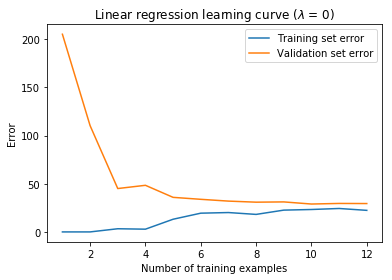

In [14]:
error_train, error_val = learning_curve(x, y, x_val, y_val, reg=0)

display_learning_curve(error_train, error_val, len(x), 0)
plt.savefig(figsdir / 'linear_regression_learning_curve.png', bbox_inches='tight')

# Polynomial regression

In [15]:
poly = PolynomialFeatures(8, include_bias=False)
poly_x = poly.fit_transform(x[:, 1].reshape(-1, 1))
poly_x_regr = poly_x.copy()
poly_x_val = poly.fit_transform(x_val[:, 1].reshape(-1, 1))

In [16]:
def feature_normalize(x):
    mu = x.mean(axis=0)
    sigma = x.std(axis=0, ddof=1)
    x_norm = np.divide(x - mu, sigma)
    
    return x_norm, mu, sigma

In [17]:
# Feature scaling

poly_x_norm, mu, sigma = feature_normalize(poly_x)
poly_x = np.c_[np.ones(poly_x.shape[0]), poly_x_norm]
poly_x_val_norm = np.divide(poly_x_val - mu, sigma)
poly_x_val = np.c_[np.ones(poly_x_val.shape[0]), poly_x_val_norm]

In [23]:
def display_fit(x, y, theta, poly, regression, reg_param, iterations, axes=None):
    if axes == None:
        axes = plt.gca()
    
    xx = np.linspace(-60, 45)
    yy = regression.intercept_ + poly.fit_transform(xx.reshape(-1, 1)).dot(regression.coef_.T)

    xx2 = np.arange(np.min(x) - 15, np.max(x) + 15, 0.05)
    poly_xx2 = poly.fit_transform(xx2.reshape(-1, 1))
    poly_xx2 = np.c_[np.ones(poly_xx2.shape[0]), np.divide(poly_xx2 - mu, sigma)]
    yy2 = poly_xx2.dot(theta)

    axes.plot(xx, yy, label='scikit-learn Ordinary Least Squares')
    axes.plot(xx2, yy2, label='Scipy minimize (CG method) ({} iterations)'.format(iterations))
    axes.scatter(x[:, 1], y, marker='x', c='r')

    axes.set_title('Polynomial regression fit ($\lambda$ = {})'.format(reg_param))
    axes.set_xlabel('Change in water level')
    axes.set_ylabel('Water flowing out of the dam')
    axes.legend(loc='best')

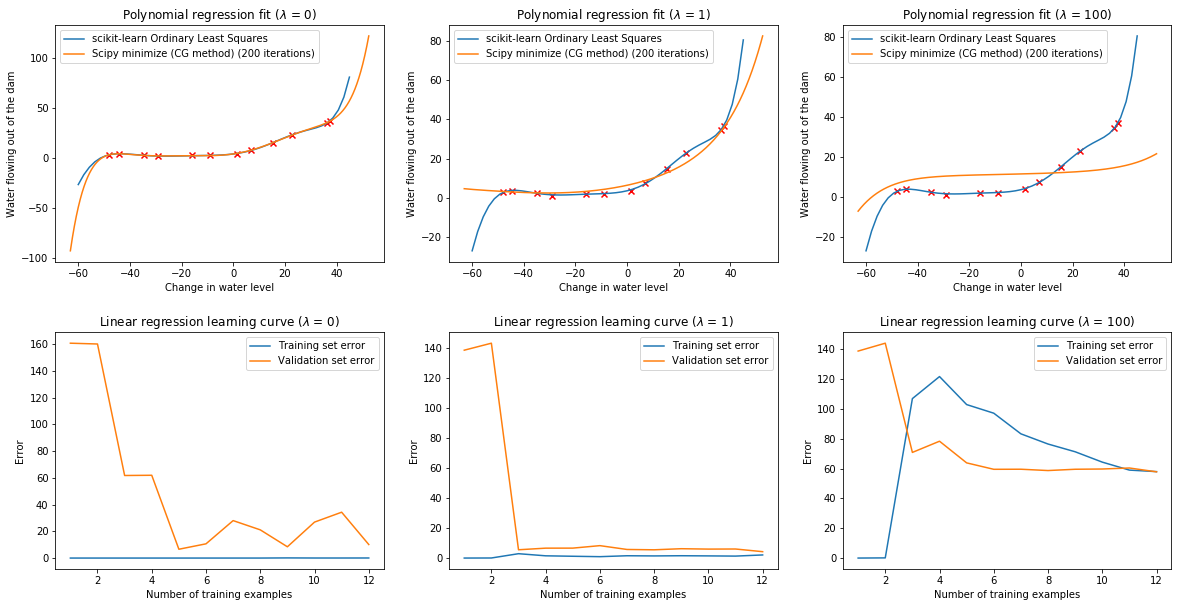

In [24]:
_, axes = plt.subplots(2, 3, figsize=(20, 10))
plt.subplots_adjust(hspace=0.3)
iterations = 200
reg = np.array([0, 1, 100])

for i in range(3):
    theta = train_regression(poly_x, y, reg[i], iterations)
    regression = LinearRegression()
    regression.fit(poly_x_regr, y)
    
    display_fit(x, y, theta, poly, regression, reg[i], iterations, axes[0, i])
    
    error_train, error_val = learning_curve(poly_x, y, poly_x_val, y_val, reg[i])
    display_learning_curve(error_train, error_val, len(poly_x), reg[i], axes[1, i])
    
plt.savefig(figsdir / 'polynomial_regression_fits_and_learning_curves', bbox_inches='tight')

In [20]:
def validationCurve(x, y, x_val, y_val):
    reg_vec = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])
    
    error_train = np.zeros(reg_vec.shape)
    error_val = np.zeros(reg_vec.shape)
    iterations = 200
    
    for i in range(reg_vec.size):
        theta = train_regression(x, y, reg_vec[i], iterations)
        error_train[i], _ = cost_function(theta, x, y, reg=0)
        error_val[i], _ = cost_function(theta, x_val, y_val, reg=0)
        
    return reg_vec, error_train, error_val

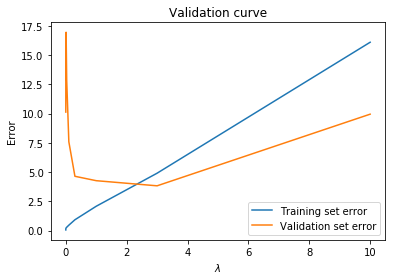

In [21]:
reg_vec, error_train, error_val = validationCurve(poly_x, y, poly_x_val, y_val)
plt.plot(reg_vec, error_train, label='Training set error')
plt.plot(reg_vec, error_val, label='Validation set error')

plt.title("Validation curve")
plt.xlabel('$\lambda$')
plt.ylabel('Error')
plt.legend(loc='best')

plt.savefig(figsdir / 'validation_curve.png', bbox_inches='tight')

In [22]:
# Load the test set

x_test = data['Xtest']
y_test = data['ytest']

# Create polynomial features and scale

poly_x_test = poly.fit_transform(x_test.reshape(-1, 1))
poly_x_test = np.divide(poly_x_test - mu, sigma)
poly_x_test = np.c_[np.ones(poly_x_test.shape[0]), poly_x_test]

# Compute the test set error

initial_theta = np.zeros(poly_x_test.shape[1])

theta = train_regression(poly_x, y, reg=3, iterations=200)
J, _ = cost_function(theta, poly_x_test, y_test, reg=0)
print('Test set error (w/ lambda = 3): {}'.format(J))

Test set error (w/ lambda = 3): 3.8598878232749945
